In [1]:
## Importamos librerías de Aprendizaje automático
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
## Importamos demas librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Introducción
En el presente notebook vamos a aprender nuestros modelos de prediccion de precios para las propiedades de Capital Federal.

In [3]:
#Importamos el dataframe y verificamos las primeras filas
capital_df = pd.read_csv('properati_capital.csv')
capital_df.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,63934,MlnOILxnUwm3KXFnNyOJig==,Propiedad,2020-07-06,2021-04-07,2020-07-06,-34.618041,-58.475124,Argentina,Capital Federal,...,1.0,NaN,NaN,89000.0,USD,NaN,Galicia 2800 Depto 2 Ambientes Con Balcón Vill...,XINTEL(JUM-JUM-313) \n\nExcelente departament...,Departamento,Venta
1,660204,FiY707h094LvsqOGHohO9Q==,Propiedad,2020-07-17,9999-12-31,2020-07-17,-34.620686,-58.453972,Argentina,Capital Federal,...,2.0,NaN,NaN,190000.0,USD,NaN,DEPARTAMENTO A ESTRENAR AL FRENTE CON COCHERA,EXCELENTE DPTO A ESTRENAR AL FRENTE CON COCHER...,Departamento,Venta
2,961496,VKAgMtgXuRfeD2XHnLPWNQ==,Propiedad,2020-06-19,2020-12-03,2020-06-19,-34.590569,-58.425215,Argentina,Capital Federal,...,2.0,98.0,68.0,360000.0,USD,NaN,Excelente departamento 4 ambientes con terraza...,Patio El Salvador . inicio de obra nmarzo 2019...,Departamento,Venta
3,292569,H56oekWpzEOKT5aXM43WLA==,Propiedad,2021-02-24,2021-03-01,2021-02-24,-34.577440,-58.485041,Argentina,Capital Federal,...,1.0,118.0,96.0,285000.0,USD,NaN,Venta depto 4 ambientes/terraza en V. Urquiza,Corredor Responsable: MARIANO AUFSEHER - CPI 4...,Departamento,Venta
4,278737,FPPomZ4bizdYOzH9KlsLDg==,Propiedad,2020-11-17,2021-04-13,2020-11-17,-34.615851,-58.439566,Argentina,Capital Federal,...,1.0,61.0,52.0,145000.0,USD,NaN,Departamento de 2 ambientes c terraza a estrenar,Corredor Responsable: MARCELO GRUNBAUM - CMCPS...,Departamento,Venta


## Resumen preprocesamiento
Aplicamos todas las modificaciones hechas al dataframe original durante el EDA.

In [4]:
capital_df.drop(labels=['id','ad_type','start_date','end_date','l1','l2','l5','l6','currency','price_period','title','description','operation_type'], axis=1, inplace = True)
capital_df['surface_total'].fillna(capital_df['surface_total'].mean(), inplace = True)
capital_df['surface_covered'].fillna(capital_df['surface_covered'].mean(), inplace = True)
capital_df['rooms'].fillna(capital_df['rooms'].median(), inplace = True)
capital_df.drop_duplicates(subset='Unnamed: 0', inplace=True, keep='last')
capital_df = capital_df.loc[capital_df.price < 350000]
capital_df = capital_df.drop(['Unnamed: 0',"l4","created_on","lat","lon","bedrooms","bathrooms"], axis=1)

In [5]:
#Verificamos que se las modificaciones se hayan ejecutado correctamente 
capital_df.head()

,l3,rooms,surface_total,surface_covered,price,property_type
1,Caballito,3.0,123.681431,94.367801,190000.0,Departamento
4,Caballito,2.0,61.000000,52.000000,145000.0,Departamento
5,Villa del Parque,3.0,66.000000,58.000000,153000.0,Departamento
7,Almagro,3.0,84.000000,70.000000,165000.0,PH
8,Palermo,1.0,33.000000,33.000000,92000.0,Departamento


In [6]:
## Obtenemos las dummies de dataset modificado y dropeamos la variable "price" a estimar
x = pd.get_dummies(data=capital_df, columns=['property_type','l3'])
x = x.drop(['price',], axis=1)

In [7]:
## Extraemos la variable "Price" y la guardamos en "y"
y = np.array(capital_df[["price"]])

In [8]:
#Dividimos el dataset en xtrain, xtest, ytrain, ytest.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=22)

In [9]:
#Separamos las variables dummies de las reales
x_train_r = xtrain.iloc[:,0:3]
x_train_d = xtrain.iloc[:,3:63]

x_test_r = xtest.iloc[:,0:3]
x_test_d = xtest.iloc[:,3:63]

In [10]:
## Escalamos ambas variables reales de x_train
scaler = preprocessing.StandardScaler().fit(x_train_r)
xtrain_scal = scaler.transform(x_train_r)
xtest_scal = scaler.transform(x_test_r)

In [11]:
## Convertimos el formato de las dummies de float64 a numpy
## Concatenamos las dummies a las variables ya escaladas
x_train_d=x_train_d.to_numpy(dtype="float64")
x_test_d=x_test_d.to_numpy(dtype="float64")
xtrain_scal = np.concatenate((xtrain_scal, x_train_d), axis = 1)
xtest_scal = np.concatenate((xtest_scal, x_test_d), axis = 1)

## Modelos machine learning
Procedemos a ejecutar dos modelos: 
1. Support Vector Regression
2. Ridge Regression

### SVR

In [12]:
## Definimos el SVR y asignamos 2 valores a cada hiperparametro
## Ejecutamos el GridSearch y CrossValidation
svreg = SVR()
param_svreg = {'kernel':('linear', 'sigmoid'), 'C':[100, 1000 ], 'gamma':[ 0.01,0.1]}
regressor_svr = GridSearchCV(svreg, param_svreg, cv=3, verbose=3)
regressor_svr.fit(xtrain_scal, ytrain.ravel())

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.363 total time=  22.3s
[CV 2/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.395 total time=  23.9s
[CV 3/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.400 total time=  19.7s
[CV 1/3] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.045 total time=  26.6s
[CV 2/3] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.039 total time=  32.8s
[CV 3/3] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.036 total time=  27.8s
[CV 1/3] END ...C=100, gamma=0.1, kernel=linear;, score=0.363 total time=  21.0s
[CV 2/3] END ...C=100, gamma=0.1, kernel=linear;, score=0.395 total time=  21.3s
[CV 3/3] END ...C=100, gamma=0.1, kernel=linear;, score=0.400 total time=  29.0s
[CV 1/3] END ..C=100, gamma=0.1, kernel=sigmoid;, score=0.288 total time=  25.8s
[CV 2/3] END ..C=100, gamma=0.1, kernel=sigmoid;, score=0.289 total time=  29.7s
[CV 3/3] END ..C=100, gamma=0.1, kernel=sigmoid;,

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [100, 1000], 'gamma': [0.01, 0.1],
                         'kernel': ('linear', 'sigmoid')},
             verbose=3)

In [13]:
## Mostramos los mejores hiperparametros
best_params1 = regressor_svr.best_params_
best_params1

{'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}

In [14]:
## Mostramos el mejor score de dichos hiperparametros
best_score1 = regressor_svr.best_score_
best_score1

0.4294303901171681

In [15]:
## Calculamos las predicciones con el modelo aprendido
ypred1 = regressor_svr.predict(xtest_scal)

In [16]:
## Calculamos RMSE
RMSE_svr_1 = np.sqrt(mean_squared_error(ytest, ypred1))
RMSE_svr_1

50346.44179161922

### Ridge Regression

In [17]:
## Definimos la funcion Ridge Regression que calculará los pesos W
def ridge_reg(x,y,lambd):
  n, m = x.shape
  I = np.identity(m)
  w = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x) + lambd * I), x.T), y)
  return w

In [18]:
## Definimos el hiperparametro costo lambda
lamb = 30

In [19]:
## Calculamos los pesos utilizando la funcion previamente definida
weights = ridge_reg(xtrain_scal,ytrain, lamb)

In [20]:
## Normalizamos los pesos obtenidos bajo norma 2
np.linalg.norm(weights, ord = 2)

262261.7261741567

In [21]:
## Guardamos los pesos en un array para poder multriplicar con xtest_scal
weights_array = np.asarray(weights)

In [22]:
## Calculamos las predicciones de xtest_scal utilizando los pesos aprendidos
ypred2 = np.dot(xtest_scal, weights_array)

In [23]:
## Calculamos RMSE
RMSE_rr_1 = np.sqrt(np.mean(np.square(ytest - ypred2)))
RMSE_rr_1

49277.7017281241

## Reduccion de la dimensionalidad
Elegimos aplicar el método **PCA** para reducir la dimensionalidad de los datos X con el fin obtener mejores resultados en ambos modelos.

In [24]:
#Importamos libreria a utlizar
from sklearn.decomposition import PCA
# Definimos la cantidad de componentes a extraer
n_comps = 55
# Definimos PCA
pca = PCA(n_components= n_comps)
# Aplicamos fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(xtrain_scal))
xpca_test= pca.transform(xtest_scal)
# Obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_

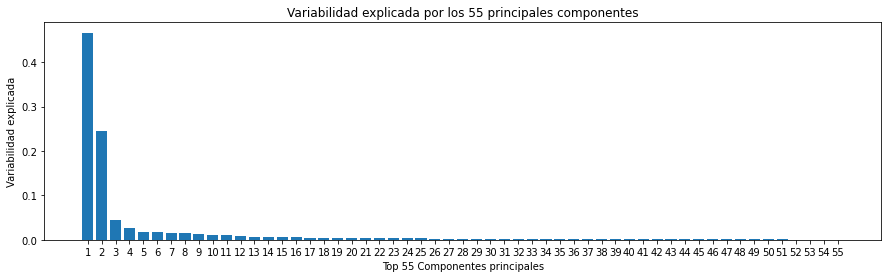

In [25]:
## Imprimimos un grafico de barras donde se muestra la variabilidad que explica cada componente
components = range(1,n_comps + 1)
plt.figure(figsize=(15,4))
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Variabilidad explicada por los ' + str(n_comps) + ' principales componentes')
plt.xlabel('Top ' +str(n_comps) + ' Componentes principales')
plt.ylabel('Variabilidad explicada')
plt.show()

## SVR (con PCA)
Volvemos a aplicar el modelo SVR con la nueva matriz de datos reducidos

In [26]:
## Utilizamos los mismos hiperparametros de GridSearch que en el SVR anterior
## Corremos el SVR con nueva matriz reducida "xpca"
regressor_svr = GridSearchCV(svreg, param_svreg, cv=3, verbose=3)
regressor_svr.fit(xpca, ytrain.ravel())

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.363 total time=  18.0s
[CV 2/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.395 total time=  20.9s
[CV 3/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.400 total time=  24.7s
[CV 1/3] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.045 total time=  31.7s
[CV 2/3] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.039 total time=  33.0s
[CV 3/3] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.036 total time=  28.8s
[CV 1/3] END ...C=100, gamma=0.1, kernel=linear;, score=0.363 total time=  20.0s
[CV 2/3] END ...C=100, gamma=0.1, kernel=linear;, score=0.395 total time=  20.3s
[CV 3/3] END ...C=100, gamma=0.1, kernel=linear;, score=0.400 total time=  19.4s
[CV 1/3] END ..C=100, gamma=0.1, kernel=sigmoid;, score=0.288 total time=  24.4s
[CV 2/3] END ..C=100, gamma=0.1, kernel=sigmoid;, score=0.291 total time=  27.6s
[CV 3/3] END ..C=100, gamma=0.1, kernel=sigmoid;,

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [100, 1000], 'gamma': [0.01, 0.1],
                         'kernel': ('linear', 'sigmoid')},
             verbose=3)

In [27]:
## Mostramos los mejores hiperparametros
best_params2 = regressor_svr.best_params_
best_params2

{'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}

In [28]:
## Mostramos el mejor score de dichos hiperparametros
best_score2 = regressor_svr.best_score_
best_score2

0.4292590634840438

In [29]:
## Calculamos las predicciones con los mejores hiperparametros aplicando SVR
ypred3= regressor_svr.predict(xpca_test)

In [30]:
## Calculamos RMSE
RMSE_svr_2 = np.sqrt(mean_squared_error(ytest, ypred3))
RMSE_svr_2

50361.20591252366

## Ridge Regression (con PCA)
Volvemos a aplicar el modelo Ridge Regression con la nueva matriz de datos reducidos

In [31]:
## Definimos la funcion Ridge Regression que calculará los pesos W
def ridge_reg(x,y,lambd):
  n, m = x.shape
  I = np.identity(m)
  w = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x) + lambd * I), x.T), y)
  return w

In [32]:
## Definimos el hiperparametro costo lambda
lamb = 30

In [33]:
## Calculamos los pesos utilizando la funcion previamente definida
weightspca = ridge_reg(xpca,ytrain, lamb)

In [34]:
## Normalizamos los pesos obtenidos bajo norma 2
np.linalg.norm(weightspca, ord = 2)

184575.36239687164

In [35]:
## Guardamos los pesos en un array para poder multriplicar con xtest_scal
weights_arraypca = np.asarray(weightspca)

In [36]:
## Calculamos las predicciones de xtest_scal utilizando los pesos aprendidos
ypred4 = np.dot(xpca_test, weights_arraypca)

In [37]:
## Calculamos RMSE
RMSE_rr_2 = np.sqrt(np.mean(np.square(ytest - ypred4)))
RMSE_rr_2

153654.21985351449

# Resumen de resultados de modelos

### SVR sin PCA

- **Mejores Hiperparametros**: {'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}
- **Score**: 0.4294
- **RMSE**: 50346.4417

### Ridge Regression sin PCA
- **Lambda**: 30
- **RMSE**: 49277.7017

### SVR con PCA

- **Mejores Hiperparametros**: {'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}
- **Score**: 0.4292
- **RMSE**: 50361.2059

### Ridge Regression con PCA
- **Lambda**: 30
- **RMSE**: 153654.2198
